# Цель проекта

Сделать несколько вариаций SVM моделей-сомелье с использованием ядерных функций и определить лучшую вариацию ядра и гиперпараметров для SVM на основании винного датасета ниже.


# Зависимости

- Python 3.11.1
- pandas==1.5.2
- numpy==1.24.1
- seaborn==0.12.2
- matplotlib==3.6.2
- scikit-learn==1.2.0
- joblib==1.2.0

# Импорт

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from joblib import Parallel, delayed

# Функции

In [2]:
"""Visualize correlateion matrix"""
def visual_corr(df): # df is a correlation matrix
    
    sns.set_style(style = 'white')
    f, ax = plt.subplots(figsize=(9, 9))

    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax,
                annot=True, center=0)
    
    
"""Split list into n chunks"""
def chunker(lst, n_chunks=12):
    lists_of_lists = []
    n_chunks = 12

    shard = len(lst)//n_chunks
    counter = 0 
    last_item = shard
    for i in range(n_chunks):
        if i == n_chunks-1:
            lists_of_lists.append(lst[counter:])
        else:
            lists_of_lists.append(lst[counter:last_item])
            counter += shard
            last_item += shard
        
    return lists_of_lists

"""Get prediction metrics for all trained models"""
def get_models_results(lst_of_params):
    results = []
    for params in lst_of_params:
        svc = SVC(**params)
        svc.fit(X_train, y_train)
        
        result = params
        result["predictions"] = svc.predict(X_test)
        results.append(result)

    return results

"""Get calculation of metrics: True positive, accuracy, biclass_metric """
class metrics:
    def __init__(self, y_test, prediction):

        comparing = pd.DataFrame([np.array(y_test), prediction]).T
        comparing.columns = ["real_values", "predictions"]

        good_true  = 0
        good_total = 0

        bad_true   = 0
        bad_total  = 0

        for i in comparing.index:
            if comparing.real_values.loc[i] == 0:
                if comparing.predictions.loc[i] == 0:
                    bad_true += 1
                bad_total += 1
            elif comparing.real_values.loc[i] == 1:
                if comparing.predictions.loc[i] == 1:
                    good_true += 1
                good_total += 1
        
        # True positives and total value counts of each class(0 and 1)
        self.for_accuracy = {"good_true": good_true,
                             "good_total": good_total,
                             "bad_true":bad_true,
                             "bad_total": bad_total}
        # atribure for getting accuracy
        self.accuracy = (good_true + bad_true) / (good_total + bad_total)
        
        # atribure for getting biclass_metric
        self.biclass_metric =  self.accuracy * (1 - 
                                  abs(good_true/ good_total 
                                      - bad_true/bad_total))

# Данные

Датасет содержит информацию о красных винах и их составе. Целевой переменной является столбец "quality". Это метрика качества вина по шкале от 3 до 8.

In [3]:
wine = pd.read_csv("winequality-red.zip", sep=";")

In [4]:
wine.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1115,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.6,11.3,6


In [5]:
print("shape :",wine.shape,"\n")
wine.info()

shape : (1599, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Все признаки числовые и не имеют пропусков:)

Так же в датасете нет id, поэтому все строки будут восприниматься как уникальные

# EDA

## граммы/дм3
Большинство показателей вин измеряются в $\frac{гр}{дм^3}$ и отражают количество веществ, влияющих на вкусовые и качественные характеристики вина.

### Нелетучие кислоты

In [6]:
wine["fixed acidity"].head(3)

0    7.4
1    7.8
2    7.8
Name: fixed acidity, dtype: float64

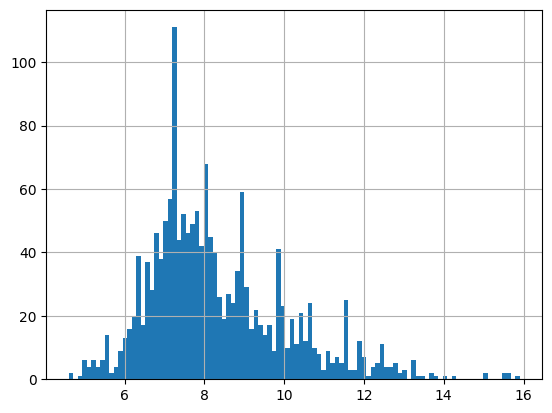

In [7]:
wine["fixed acidity"].hist(bins=100);

Логнормальное распределение с бугорком вначале. Значения в пределах нормы, длинного хвоста нет, признак готов для модели.

### Летучие кислоты

Чем больше, тем более вино похоже на уксус

In [8]:
wine["volatile acidity"].head(3)

0    0.70
1    0.88
2    0.76
Name: volatile acidity, dtype: float64

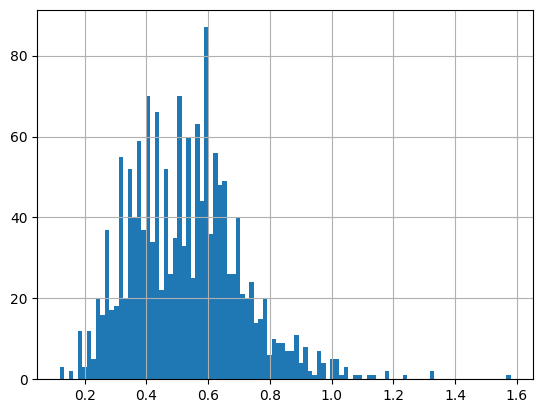

In [9]:
wine["volatile acidity"].hist(bins=100);

Кажется, есть две основые группы вина по уксусности с разделением в 0.45 $\frac{гр}{дм^3}$ Данные годятся для модели

### Лимонная кислота
Может добавить вкуса и аромата

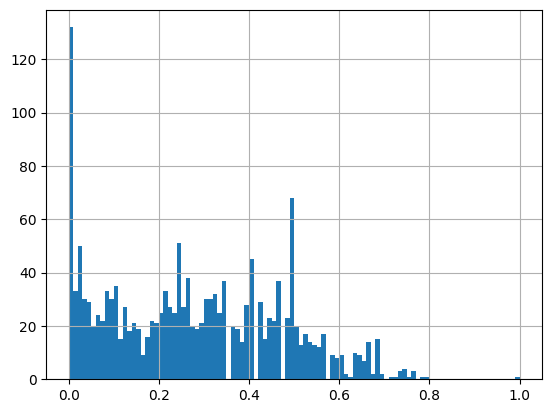

In [10]:
wine["citric acid"].hist(bins=100);

Есть вина, которые её не содержат. Довольно равномерное распределение слегка тяготеющие к минимуму. Колонка годится для модели.

### Оставшийся сахар
Который не забродил ввиду крепости напитка, недостаточной выдержанности или в угоду технологическому трюку и задумке автора

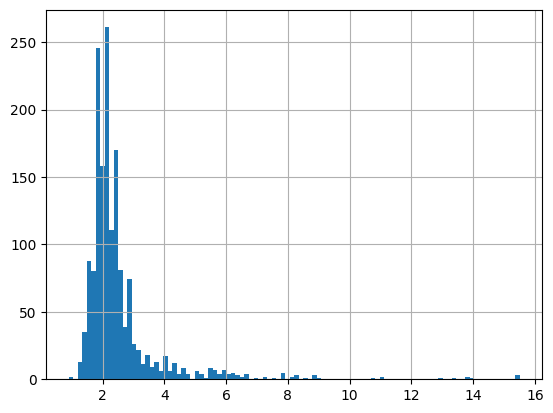

In [11]:
wine["residual sugar"].hist(bins=100);

Логнормальное распределение, есть длинный хвост, значения можно логарифмизировать, признак подходит для модели

### Хлориды

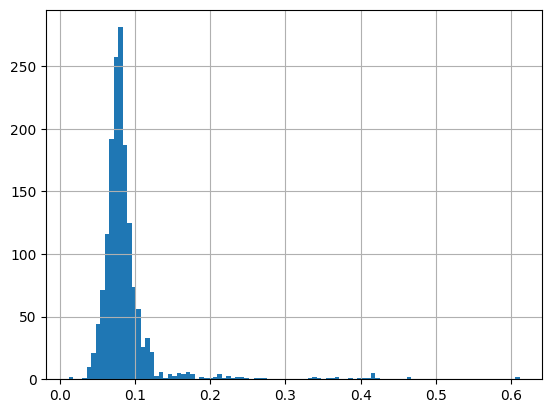

In [12]:
wine.chlorides.hist(bins=100);

Распределён нормально очень острый пик, есть длинный хвост в сторону больших значений, можно логарифмировать значения, в целом признак подходит для модели

### S02 Свободный
свободный диоксид серы: свободная форма $SO_2$ существует в равновесии между молекулярным $SO_2$ (в виде растворенного газа) и бисульфит-ионом; предотвращает рост микробов и окисление вина

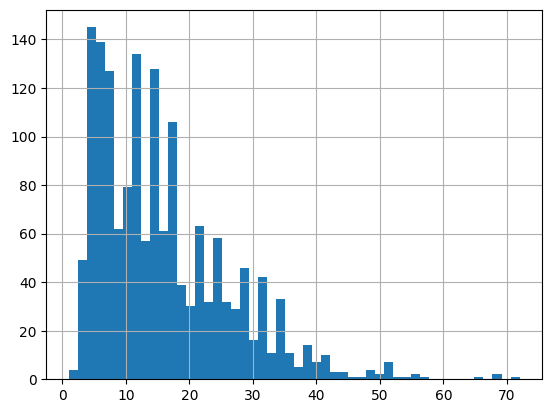

In [13]:
wine["free sulfur dioxide"].hist(bins=50);

Логнормальное распределение, признак подходит для модели

### S02 Общий
Общий диоксид серы: количество свободной и связанной форм $SO_2$; при низких концентрациях $SO_2$ практически не обнаруживается в вине, но при концентрациях свободного $SO_2$ более 50 частей на миллион$SO_2$ становится заметным в аромате и вкусе вина

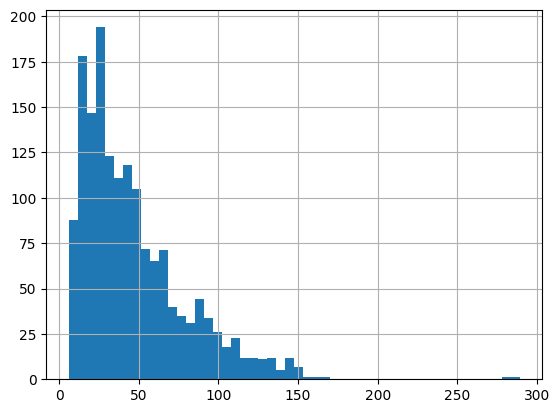

In [14]:
wine["total sulfur dioxide"].hist(bins=50);

In [15]:
wine["total sulfur dioxide"].sort_values(ascending=False).iloc[:10]

1081    289.0
1079    278.0
354     165.0
1244    160.0
651     155.0
109     153.0
684     152.0
672     151.0
515     151.0
591     149.0
Name: total sulfur dioxide, dtype: float64

Есть два выброса. позволительно от них избавиться

In [16]:
wine = wine.drop(wine["total sulfur dioxide"]
          .sort_values(ascending=False).iloc[:2].index, axis="rows")

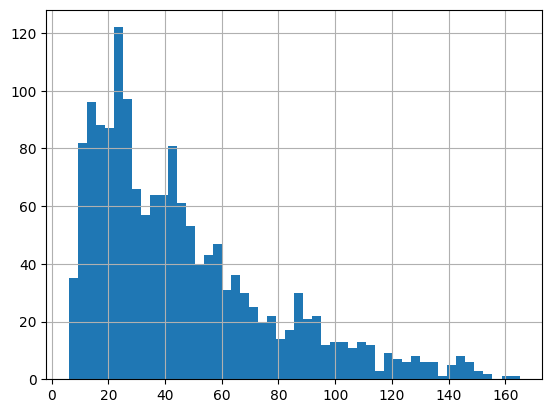

In [17]:
wine["total sulfur dioxide"].hist(bins=50);

Красивое логнормальное распределение, признак подходит для модели

### Сульфаты
добавка к вину, которая может способствовать повышению уровня сернистого газа ($SO_2$), действующая как противомикробное и антиоксидантное средство.

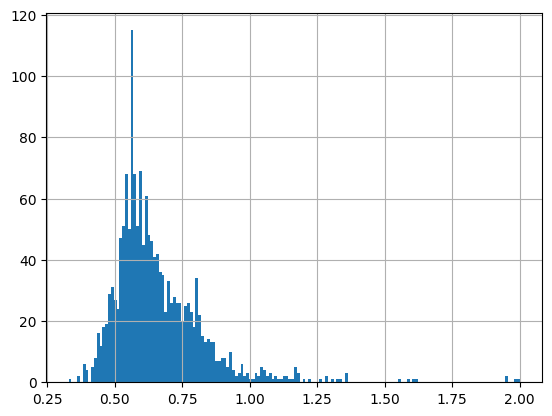

In [18]:
wine.sulphates.hist(bins=160);

Хорошее распределение, что-то среднее между логнормальным и нормальным, признак пойдёт в модель

## Плотность

В $\frac{гр}{дм^3}$

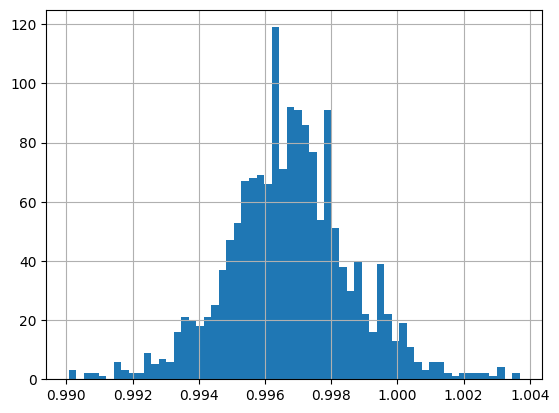

In [19]:
wine.density.hist(bins=60);

Плотность распределена нормально, числовые значения подходят под модель

## pH
Кислотность вина по шкале pH. Нормальные значения для вина от 2х до 4х, находящиеся в кислом диапазоне

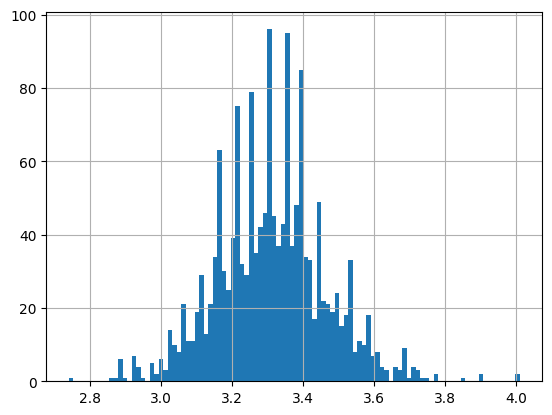

In [20]:
wine.pH.hist(bins=100);

Кислотность распределена нормально, признак подходит для модели

## Алкоголь
Процент от объема жидкости содержания этилового спирта

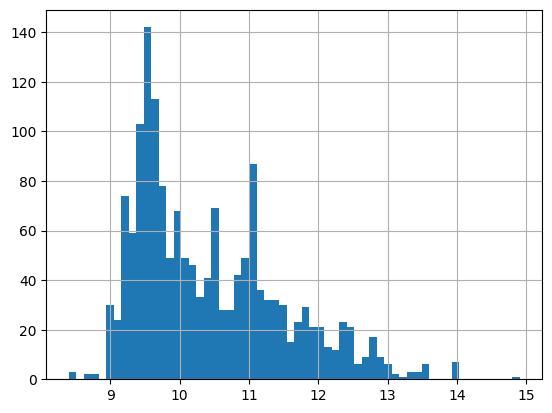

In [21]:
wine.alcohol.hist(bins=60);

In [22]:
print(f"Представленные вина содержат от {wine.alcohol.min()} до {wine.alcohol.max()} градусов алкоголя")

Представленные вина содержат от 8.4 до 14.9 градусов алкоголя


Признак подходит для модели

## Оценка 

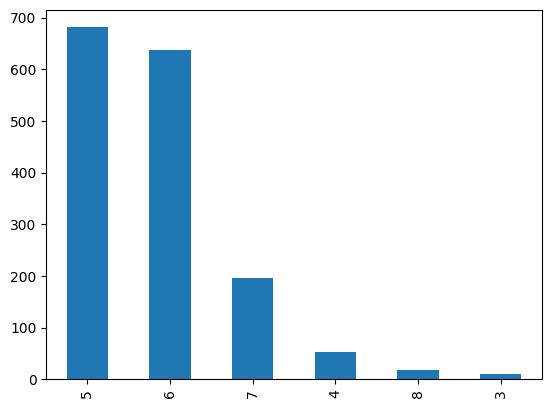

In [23]:
wine.quality.value_counts().plot(kind="bar");

Вина в датасете оценивают от 3 до 8 баллов.

Взглянем на корреляцию признаков с оценкой

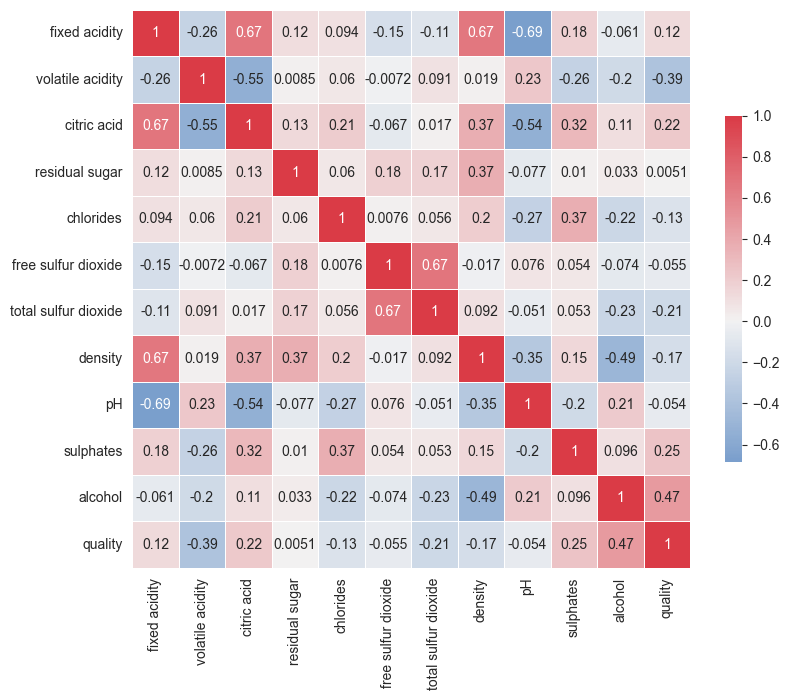

In [24]:
visual_corr(wine.corr())

Слабее всего на оценку влияет количество остаточного сахара, А сильнее всего - содержание алкоголя и летучих кислот. Пожалуй из выборки можно убрать сахар, но пока-что посмотрим как модель отреагирует на данные. В целом признаки ценные.

# Предобработка

Стоит задача классификации вина на плохое и хорошее по его характеристикам, поэтому превратим числовой признак оценки в категориальный

In [25]:
wine_is_good = []

for value in wine.quality:
    if value >= 6.5: wine_is_good.append(1)
    else: wine_is_good.append(0)
    
wine_is_good = pd.Series(wine_is_good)

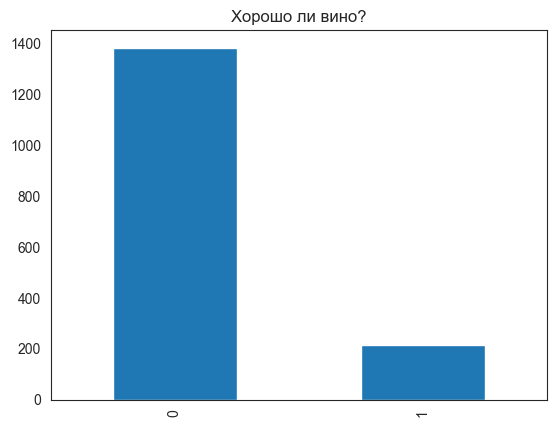

In [26]:
wine_is_good.value_counts().plot(kind="bar", title="Хорошо ли вино?");

О нет, выборка неравномерна и плохого вина намного больше! Это значит, что для accuracy как метрики нужно будет уравнять количество плохого и хорошего вина. Или же стоит использовать другую метрику

## Выборки 

Получим массив признаков X

In [27]:
X = wine.drop("quality", axis="columns")

Стандартизируем данные, чтобы модель дала лучший резльутат.

In [28]:
std_sca = StandardScaler()
std_sca.fit(X)
X = std_sca.transform(X)

Получим вектор таргета y

In [29]:
y = wine_is_good

Разделим выборку на тренировочную и тестовую

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

# Моделирование

## Валидация

Будем использовать несколько метрик:
- Во первых сбывшиеся предсказания обоих типов вин и общее количество их же в тестовой выборке
- Во вторых accuracy, чтобы показать отличия метрики, про которую расскажу ниже
- В третьих метрика, которую я назвал biclass_metric. Уверен, её придумали 200 лет назад до меня, но мне не интересно искать её, мне было интересно её сделать:)

### biclass_metric

Является модификацией accuracy, благодяря которой можно сделать последнюю чувствительной к соотношению классифицируемых объектов в выборке. Она помогает уравнять перевес. Важно заметить, что в своей идее и применении она работает на бинарной классификации, но её можно модифицировать и под большее количество классов.

$$accuracy * (1 - |\frac{True\ Predictions_1}{Total\ Objects_1} -  \frac{True\ Predictions_2}{Total\ Objects_2}|)$$
- $True/ Predictions_1$ - количество верных предсказаний 1 класса объектов 
- $Total/ Objects_1$ - количество всех объектов 1 класса в выборке. Индекс 2 аналогично обозначаент 2 класс объектов



## SVM без ядра

In [31]:
lsvc = LinearSVC(max_iter=5000)
lsvc.fit(X_train, y_train)

metric = metrics(y_test, lsvc.predict(X_test))
display(pd.DataFrame(metric.for_accuracy, index=["LinearSVC"]))
print("accuracy      ", metric.accuracy)
print("biclass_metric", metric.biclass_metric)

,good_true,good_total,bad_true,bad_total
LinearSVC,12,48,343,352


accuracy       0.8875
biclass_metric 0.2445667613636363


Модель показала слабое значение на оценке хорошего вина, будет бейслайном.

## SVM с разными ядрами и параметрами

Буду перебирать параметры для моделей в сетке

In [32]:
param_grid = dict(gamma=[0.03, 0.09, 0.3, 0.7, 1, 3],
                  C=[0.01, 0.1, 1, 10, 100],
                  kernel=['linear', 'poly', 'rbf', 'sigmoid'])
param_grid

{'gamma': [0.03, 0.09, 0.3, 0.7, 1, 3],
 'C': [0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

GridSearch считает показатели моделей по его собственным метрикам и я не нашёл, как вставить свои, поэтому перебор мой собственный.

Ниже не самый изящный, но рабочий метод формирования перебора всех значений в сетке. 

In [33]:
list_of_keys = list(param_grid.keys())


lst_of_params = []
for v0 in (param_grid[list_of_keys[0]]):
    for v1 in (param_grid[list_of_keys[1]]):
        for v2 in (param_grid[list_of_keys[2]]):
            lst_of_params.append(
                      {list_of_keys[0]:v0,
                       list_of_keys[1]:v1,
                       list_of_keys[2]:v2})

In [34]:
print("Всего вариаций SVC модели:", len(lst_of_params))

Всего вариаций SVC модели: 120


In [35]:
%%time

# parallel fitting of models
results = Parallel(n_jobs=-1)(delayed(get_models_results)(x)
                                  for x in chunker(lst_of_params))
# change results format to neded
models_predicitons = []
for i in results:
    for j in i:
        models_predicitons.append(j)

CPU times: total: 46.9 ms
Wall time: 3min 10s


## Результаты

Ещё раз напомню, что для валидности результатов accuracy нужно соблюдать равные пропорции выборки. Поскольку моя тестовая выборка, как и тренировочная, состоит в основном из плохого вина, то я выбрал свой метод отражения качества модели.

In [36]:
a = models_predicitons[0]

metric = metrics(y_test, a["predictions"])
display(pd.DataFrame(metric.for_accuracy, index=["LinearSVC"]))
print("accuracy      ", metric.accuracy)
print("biclass_metric", metric.biclass_metric)

,good_true,good_total,bad_true,bad_total
LinearSVC,0,48,352,352


accuracy       0.88
biclass_metric 0.0


Выше пример, в котором модель имеет нулевую классификационную способность и не угадала ни одного хорошего вина, но при этом результат accuracy большой.

А метрика, про которую я рассказал в разделе валидации отразила суть - данная модель абсолютно не пригодна для прогнозирования

Посмотрим же на результаты всех комбинаций!

In [37]:
validation = []
for dct in models_predicitons:
    metric = metrics(y_test, dct["predictions"])
    future_row = dct.copy()
    del future_row["predictions"]
    future_row["biclass_metric"] = metric.biclass_metric
    future_row["accuracy"] = metric.accuracy
    validation.append(future_row)    
    
validation = pd.DataFrame(validation)
validation.sample(5)

,gamma,C,kernel,biclass_metric,accuracy
96,1.00,100.0,linear,0.000000,0.8800
95,1.00,10.0,sigmoid,0.327689,0.8200
106,3.00,0.1,rbf,0.000000,0.8800
18,0.03,100.0,rbf,0.426989,0.9000
75,0.70,10.0,sigmoid,0.284453,0.8275


Получилось 120 вариантов модели с разными параметрами, выведем 10 лучших из них по моей метрике

In [38]:
validation.sort_values("biclass_metric", ascending=False).iloc[:10]

,gamma,C,kernel,biclass_metric,accuracy
105,3.00,0.1,poly,0.732448,0.8575
57,0.30,100.0,poly,0.732448,0.8575
73,0.70,10.0,poly,0.712147,0.8575
89,1.00,1.0,poly,0.711780,0.8600
38,0.09,100.0,rbf,0.698712,0.9200
93,1.00,10.0,poly,0.692259,0.8550
77,0.70,100.0,poly,0.674917,0.8375
109,3.00,1.0,poly,0.655090,0.8375
69,0.70,1.0,poly,0.652794,0.8500
53,0.30,10.0,poly,0.649569,0.8650


Получилось сразу два варианта с лучшими показателями модели, оба используют ядро "poly", на 5 строчке затесалось ядро RBF. Выведем победителя

In [39]:
svc = SVC(gamma=0.3, C=100, kernel="poly")
svc.fit(X_train, y_train)


prediciton = svc.predict(X_test)

metric = metrics(y_test, prediciton)
display(pd.DataFrame(metric.for_accuracy, index=["LinearSVC"]))
print("accuracy      ", metric.accuracy)
print("biclass_metric", metric.biclass_metric)

,good_true,good_total,bad_true,bad_total
LinearSVC,35,48,308,352


accuracy       0.8575
biclass_metric 0.7324479166666666


10 лучших по accuracy:

In [40]:
validation.sort_values("accuracy", ascending=False).iloc[:10]

,gamma,C,kernel,biclass_metric,accuracy
38,0.09,100.00,rbf,0.698712,0.9200
90,1.00,1.00,rbf,0.330161,0.9175
118,3.00,100.00,rbf,0.286719,0.9175
114,3.00,10.00,rbf,0.286719,0.9175
98,1.00,100.00,rbf,0.417045,0.9175
94,1.00,10.00,rbf,0.417045,0.9175
70,0.70,1.00,rbf,0.331861,0.9150
78,0.70,100.00,rbf,0.464479,0.9100
110,3.00,1.00,rbf,0.227500,0.9100
61,0.70,0.01,poly,0.442936,0.9100


Обратная ситуация, на этой стороне превалирует rbf

Лучший результат модели, найденный с помощью ядра poly на основании топовых значений

In [41]:
svc = SVC(gamma=0.25, C=200, kernel="poly")
svc.fit(X_train, y_train)


prediciton_poly = svc.predict(X_test)

metric = metrics(y_test, prediciton)
display(pd.DataFrame(metric.for_accuracy, index=["SVC with poly"]))
print("accuracy      ", metric.accuracy)
print("biclass_metric", metric.biclass_metric)

,good_true,good_total,bad_true,bad_total
SVC with poly,35,48,308,352


accuracy       0.8575
biclass_metric 0.7324479166666666


Лучший результат модели, найденый с помоощью ядра rbf на основании топовых значений

In [42]:
svc = SVC(gamma=0.09, C=90, kernel="rbf")
svc.fit(X_train, y_train)


prediction_rbf = svc.predict(X_test)

metric = metrics(y_test, prediction_rbf)
display(pd.DataFrame(metric.for_accuracy, index=["SVC with RBF"]))
print("accuracy      ", metric.accuracy)
print("biclass_metric", metric.biclass_metric)

,good_true,good_total,bad_true,bad_total
SVC with RBF,35,48,336,352


accuracy       0.9275
biclass_metric 0.7184611742424242


Судя по всему rbf - любитель плохого вина, а poly - любитель хорошего. Что, если совместить результаты двух этих ядер для лучшего результата?

In [43]:
prediciton_poly_rbf = []

for i in (prediciton_poly + prediction_rbf):
    # if good wine assumptions intersecting than we need just 1
    if i == 2: prediciton_poly_rbf.append(1) 
    else:      prediciton_poly_rbf.append(i)

In [44]:
metric = metrics(y_test, prediciton_poly_rbf)
display(pd.DataFrame(metric.for_accuracy, index=["SVC with RBF"]))
print("accuracy      ", metric.accuracy)
print("biclass_metric", metric.biclass_metric)

,good_true,good_total,bad_true,bad_total
SVC with RBF,40,48,308,352


accuracy       0.87
biclass_metric 0.83375


Вау! Модель отлично подучилась предсказывать хорошие вина, такие предсказания ценнее чем потери в угадывании плохих вин и метра отличная

Вывод: "poly" и "rbf" ядра показали наилучший результат, а их ответы оказались совместимыми для улучшения качества модели